# AGBench 🌴🛰

We introduce the package AGBench: an end-to-end method to benchmark an aboveground biomass (AGB) or carbon estimation map with real field data.

## Datasets
For this Jupyter notebook we use the following datasets:
- Reforestation Field Data 
    - 6 sites of ~0.5ha each of tropical agroforestry of banana and cacao in Ecuador
    - each tree has manually been measured (species&DBH) to determine AGB and carbon
    - drone imagery of each site
 
- [Global Forest Watch's Aboveground Woodly Biomass](https://data.globalforestwatch.org/datasets/gfw::aboveground-live-woody-biomass-density/about)
    - a global map of AGB and carbon density at a 30x30m resolution
- Spawn et al (2020): [Global Aboveground and Belowground Biomass Carbon Density Maps for the Year 2010](https://doi.org/10.3334/ORNLDAAC/1763)
    - a global map of AGB and carbon density at a 300x300m resolution
- Santoro et al. (2018): [GlobBiomass - Global Datasets of Forest Biomass](https://doi.org/10.1594/PANGAEA.894711)
    - a global map of AGB and carbon density at a 100x100m resolution

    
----   
### 👉🏼 Remark: 
This code is currently only suited for AGB density (tons/ha) benchmarks. With small improvements of the code it can also be used to benchmark total AGB (tons), total carbon (tons), or carbon density (tons/ha)

## Packages and modules

### Install requirements
Depending on the packages and the environment on your machine, you may face different errors in the steps below. 

You can try doing pip install separately for the packages that have not been successfully installed from requirements.txt.

In [ ]:
%pip install -r ../requirements.txt

# you can include the flag -Ur like this to upgrade all the packages listed in the requirements.txt file to the latest version, but this may take a while to run
# !pip install -Ur ../requirements.txt

### Import packages

In [2]:
import os
import sys
package = os.path.dirname(os.getcwd())
sys.path.append(package)
sys.path.append(package + '/utils')

import matplotlib.pylab as plt
import seaborn as sns
sns.set_theme()
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.plot import reshape_as_image
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None
from PIL import Image
import cv2

We are importing the important functions from the script processing.py and visualization.py here.

In [3]:
from processing import *
from visualization import *

## Field data

In [5]:
path_to_AGBench = ".."

In [6]:
# Load field data of AGB and carbon of the sites using F-strings
field_data = pd.read_csv(f'{path_to_AGBench}/data/field_data/benchmark_field_data.csv', index_col = 0)

field_data

,site no,size (ha),no trees,no species,total AGB (tons),AGB density (tons/ha),carbon (tons),carbon density (tons/ha),lat_min,lat_max,lon_min,lon_max
0,0,0.508862,743,18,8.016650,15.754089,4.890156,9.609994,-1.151066,-1.150246,-79.580010,-79.579050
1,1,0.620030,929,22,15.479821,24.966259,9.442691,15.229418,-2.181593,-2.180797,-79.576656,-79.575709
2,2,0.527421,846,15,12.117345,22.974693,7.391581,14.014563,-1.201982,-1.201137,-79.593623,-79.592784
3,3,0.481253,789,20,9.685189,20.124929,5.907965,12.276207,-2.230136,-2.229287,-79.541841,-79.541064
4,4,0.465489,484,12,4.867900,10.457600,2.969419,6.379136,-1.198929,-1.198126,-79.591481,-79.590808
5,5,0.556619,872,14,15.366683,27.607191,9.373677,16.840386,-1.129809,-1.129192,-79.594727,-79.593811


## Satellite-based AGB maps that we will benchmark

### Download the data from websites

#### Global Forest Watch 

1. Go to https://data.globalforestwatch.org/datasets/e4bdbe8d6d8d4e32ace7d36a4aec7b93_0/about
2. Click on View Data Table in the Details > Record section on the right of the page.
3. Find the row starting with 00N_080W and click on the Mg_ha-1_download link. Create a new folder AGB_maps in the data folder and save it there. It's very heavy and will take a few minutes to download.

This is an updated instruction that worked for Autumn in 2024. The original instruction by Gyri is below:

There are two options to download:
1. Please download the .tif file directly [here](http://gfw2-data.s3.amazonaws.com/climate/WHRC_biomass/WHRC_V4/Processed/00N_080W_t_aboveground_biomass_ha_2000.tif)
2. or go to the GWF [dataset site](https://data.globalforestwatch.org/datasets/8f93a6f94a414f9588ce4657a39c59ff_1/explore?location=6.711245%2C0.000000%2C2.09&showTable=true) and download the file called "*00N_080W_t_aboveground_biomass_ha_2000.tif*".

When it is downloaded, place it in the folder "*data/AGB_maps*".

Autumn, 2024: *When I followed the instruction above, the first option was very slow for me. The second option can only be accessed if already signed into ArcGIS. I had to search online to create an ArcGIS Public Account first. Then I encountered a page not found when clicking into this link again.*

#### Santoro 
2024 instruction:

1. Go to https://doi.pangaea.de/10.1594/PANGAEA.894711
2. Scroll down to the Download Data section and click on "View dataset as HTML"
3. Download the file named N00W100_agb. 

If it takes too long to load, you can try out this way:
1. Go to https://globbiomass.org/wp-content/uploads/GB_Maps/Globbiomass_global_dataset.html
2. Scroll (all the way) down to the world map. Click on the word "AGB" in the tile that contains Ecuador, and download should automatically start. As Ecuador lies very near the edge of two tiles, make sure that you are downloading the one with the name N00W100_agb, not N40W100_agb.

Then unzip the folder and move the .tif file to the right location (in our directory structure, it is in AGBench/data/AGB_maps)

#### Spawn
2024 instruction:

1. Go to https://daac.ornl.gov/cgi-bin/dsviewer.pl?ds_id=1763


### Load data

We are showing how to do this for GFW, but the process should be very similar for Santoro and Spawn datasets. You just need to change the path passed into rasterio.open() below.

In [11]:
# Opening in Global Forest Watch raster data
path_to_map_raster = os.path.join(path_to_AGBench + '/data/AGB_maps/00N_080W_t_aboveground_biomass_ha_2000.tif')
GFW_satellite_raster = rasterio.open(path_to_map_raster, 'r')
GFW_map_values = GFW_satellite_raster.read(1) 

In [7]:
# Show the full map (will take ~ 10 seconds)
print(GFW_map_values.shape)

(40000, 40000)


In [8]:
# Verify that the satellite map has the right EPSG:4326 standard and bounds: BoundingBox(left=-80.0, bottom=-10.0, right=-70.0, top=0.0)
print("Satellite details: {}".format(GFW_satellite_raster.crs))
print(GFW_satellite_raster.bounds)

Satellite details: EPSG:4326
BoundingBox(left=-80.0, bottom=-10.0, right=-70.0, top=0.0)


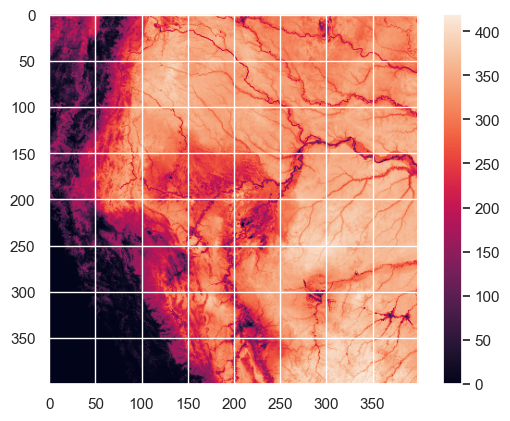

In [9]:
from skimage.measure import block_reduce
import numpy as np

# Downsample the data by a factor of 100 in each dimension
downsample_factor = 100
downsampled = block_reduce(GFW_map_values, block_size=(downsample_factor, downsample_factor), func=np.mean)

# Now visualize the downsampled data
plt.imshow(downsampled)
plt.colorbar()
plt.show()

## ReforesTree drone imagery

### Download the ReforesTree dataset
From this Dropbox link: https://www.dropbox.com/scl/fo/qzlq48k06dbksvrl3kk1o/h?rlkey=hpq3r63b1tbpqa02f5tyh8l6s&e=1&dl=0.

### Loading drone images from local directory

In [8]:
path_to_reforestree_data = '/Users/autumn_yngoc/Downloads/Data Science AIT/ReforesTree/full_reforestree_data_dropbox/'
trees = pd.read_csv(path_to_reforestree_data + 'field_data.csv')


site_no = int(input("Enter the number between 0 and 5 to explore a site among these 6 sites: ['Nestor Macias RGB', 'Leonor Aspiazu RGB', 'Carlos Vera Arteaga RGB', 'Carlos Vera Guevara RGB', 'Flora Pluas RGB', 'Manuel Macias RGB']")) 

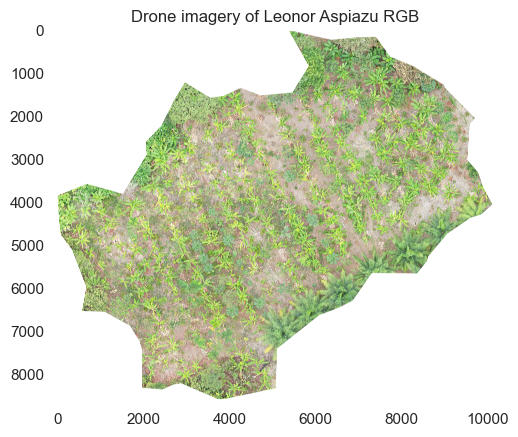

In [9]:
# Load correctly cropped drone imagery 
from processing import raster_to_image # if facing error, try from from AGBench.utils.processing import raster_to_image


path = path_to_reforestree_data + 'wwf_ecuador/RGB Orthomosaics/Cropped/{}_cropped.tif'.format(trees.site.unique()[site_no])
drone_raster = rasterio.open(path)
drone_image, white_pixels = raster_to_image(drone_raster)

plt.title(f'Drone imagery of {trees.site.unique()[site_no]}')
plt.grid(False)
plt.imshow(drone_image)
plt.show()
                                 

## Benchmark for one field site
Now, we will benchmark the satellite-based AGB map against our field data. First, we will need to crop the satellite-based map using our drone images.

### Pre-Processing

Let's make our low resolution (LR) satellite-based map fit the high resolution (HR) overlapping the GPS coordinates of the drone plot. 


The steps are as follows, we:
1. cut the LR satellite map with a padding around the polygon of the site to reduce computation intensity
    - output: **map_crude**
2. linearly interpolate the values for this map and resize the map with the same HR pixel resolution as the drone imagery 
    - output: **map_resized**
3. cut the map further fitting with the GPS locations of the drone imagery 
    - output: **map_fitted**
4. filter out the site area by removing all pixels in the satellite-based map, that are outside of the drone imagery, coloured white 
    - output: **map_filtered**

In [17]:
# Steps 1 to 3
map_crude, map_resized, map_fitted = crop_map_to_site(GFW_satellite_raster, GFW_map_values, 
                                                      drone_raster, drone_image, field_data, site_no)

In [18]:
# Step 4
map_filtered = white_pixels*map_fitted

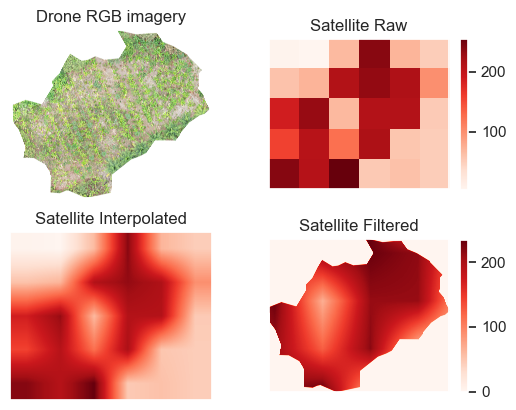

In [19]:
# Visualize the 4 steps

plot_all_sites(drone_image, map_crude, map_resized, map_filtered, site_no)
# Save plot
plt.savefig('{}/data/results/fig_site_{}_combi.png'.format(path_to_AGBench, site_no), dpi=300)

### Analysis
Is the map accurately estimating the amount or density of AGB/carbon? We will pass our data into the helpful functions from the processing.py script.

In [20]:
compare_mean_AGB_density (field_data, site_no, map_crude, map_fitted, map_filtered)

Mean AGB density:
25.0  : field data (ground truth)
132.1 : map_crude    : x5.3  
158.7 : map_fitted   : x6.4  
174.2 : map_filtered : x7.0  
The satellite-based map over/underestimates by a factor of 7.0


## Benchmark for all field sites

In [13]:
# Run the benchmark for all sites
map_name = 'GFW' # Global Forest Watch

results = pd.DataFrame(columns=['site no', 'AGB density (field data)'])

print('Ready to benchmark!')

for site_no in range(0, len(field_data)):
    path = path_to_reforestree_data + 'wwf_ecuador/RGB Orthomosaics/Cropped/{}_cropped.tif'.format(trees.site.unique()[site_no])
    drone_raster = rasterio.open(path)
    drone_image, white_pixels = raster_to_image(drone_raster)
    
    
    # Steps 1 to 3
    print('step 1-3')
    map_crude, map_resized, map_fitted = crop_map_to_site(GFW_satellite_raster, GFW_map_values, drone_raster, drone_image, field_data, site_no)
    
    # Step 4
    print('step 4')
    map_filtered = white_pixels*map_fitted
    
    # Visualize and save an image of the 4 steps
    #plot_all_sites(drone_image, map_crude, map_resized, map_filtered, site_no)
    
    # Compare and store the values
    results = AGB_density_analysis(results, field_data, site_no, map_filtered, map_name)
    
    print('Site {} is done.'.format(trees.site.unique()[site_no]))
    
results.to_csv('{}/data/results/results_{}.csv'.format(path_to_AGBench, map_name))
    

Ready to benchmark!
step 1-3
step 4
Site Nestor Macias RGB is done.
step 1-3
step 4
Site Leonor Aspiazu RGB is done.
step 1-3
step 4
Site Carlos Vera Arteaga RGB is done.
step 1-3
step 4
Site Carlos Vera Guevara RGB is done.
step 1-3
step 4
Site Flora Pluas RGB is done.
step 1-3
step 4
Site Manuel Macias RGB is done.


🎉 The final results 🔥

In [14]:
results 

,site no,AGB density (field data),AGB density (estimation from GFW),Factor for GFW
0,0,16.0,193.0,12.2
1,1,25.0,174.0,7.0
2,2,23.0,49.0,2.1
3,3,20.0,74.0,3.7
4,4,10.0,10.0,0.9
5,5,28.0,131.0,4.8
